# Outlier 2021: Inching back to normality

Despite hopes for a return to the pre-pandemic _status quo ante_, 2021 remained in the shadow of COVID. Though at times it seemed that the virus itself had diminished as a force, the supply-chain chaos it wrought was a constant factor throughout the year.

This means that we should not read too much into the data for this year &mdash; the situation was inching back to normality, but not yet there. Nonetheless, there is, as always, some insight to be gained by looking at the numbers. So let us get to it.

In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils, plots

import pandas as pd
import numpy as np
import scipy
import os
import os.path
from IPython.display import display, HTML
import utils
import plots
import altair as alt

alt.renderers.enable('mimetype')

year = 2021
df_all = utils.outlier_df('../../outlier-data.csv', year)
# df_all = utils.outlier_df('../../../outlier/public/outlier-data.csv', year)

In [2]:
# rel = df_all.iloc[0]['Release'].to_pydatetime()
# text = f"""<p><i>(Provisional analysis of Outlier 2021 drops up to {rel.strftime("%b %d, %Y")})</i></p>"""
# display(HTML(text))

**Contents**
* _The Rundown_
* _Re-ups_
* _Colors_
* _Fabrics_

In [3]:
# Filter to Clothes
def type_to_kind(drop_type):
    if drop_type == "T-Shirt" or drop_type == "Shirt" or drop_type == "Tank Top":
        return "Top"
    if drop_type == "Pants" or drop_type == "Shorts":
        return "Bottom"
    return "Layer"


def row_to_subkind(row):
    drop_type = row['Type']
    if drop_type == "T-Shirt" or drop_type == "Shirt":
        pass
    elif drop_type == "Pants" or drop_type == "Shorts":
        pass
    elif drop_type == "Tank Top":
        drop_type = 'T-Shirt'
    else:
        drop_type = "Layer"
    exp = "Exp" if row['Exp'] else "Regular"
    return "{}/{}".format(drop_type, exp)


def object_type_to_kind(drop_type):
    if drop_type == "Backpack" or drop_type == "Bag" or drop_type == "Dopp Kit" \
       or drop_type == "Dufflebag" or drop_type == "Pouch":
        return "Bag"
    if drop_type == "Balaclava" or drop_type == "Bandana" or drop_type == "Scarf":
        return "Scarf/Bandana"
    if drop_type == "Cap" or drop_type == "Hat" or drop_type == "Hood":
        return "Headgear"
    if drop_type == "Bathrobe" or drop_type == "Robe" or drop_type == "Towel" \
       or drop_type == "Outerwear" or drop_type == "Keychain" or drop_type == "Socks":
        return "Misc"
    if drop_type == "Mask" or drop_type == "Belt":
        return drop_type     
    return "Misc"


def drops_to_clothes_drops(df):
    df_clothes = pd.DataFrame(df.loc[df['Category'] == 'Clothes', :])
    df_clothes['Type'] = df_clothes['Type'].replace({'Sweatshirt':'Sweater'})
    df_clothes["Kind"] = df_clothes['Type'].apply(type_to_kind)
    df_clothes["Subkind"] = df_clothes.apply(row_to_subkind, axis=1)
    return df_clothes


# Define some reused frames
all_products_df = utils.drops_to_products(df_all, ['Year', 'Product'], 2021)
df_all['ColorCount'] = df_all['Colors'].str.split(',').dropna().apply(lambda d: len(d))

df_clothes = drops_to_clothes_drops(df_all)
clothes_products_df = utils.drops_to_products(df_clothes, ['Year', 'Product', 'Kind'], 2021)

df_objects = pd.DataFrame(df_all.loc[df_all['Category'] == 'Objects', :])
df_objects["Kind"] = df_objects['Type'].apply(object_type_to_kind)
objects_products_df = utils.drops_to_products(df_objects, ['Year', 'Product', 'Kind'], 2021)


kind_sort_order = ['Bottom', 'Top', 'Layer']
object_kind_sort_order = ['Bag', 'Mask', 'Scarf/Bandana', 'Headgear', 'Belt', 'Other']
year_sort = list(range(year, 2012, -1))
recent_year_sort = list(range(year, 2017, -1))
adjusted_price_col = f"Price-{year}"

In [4]:
ytd_dt = df_all.iloc[0]['Release']
ytd_mask = (df_all['Release'].dt.month < ytd_dt.month) | (
    (df_all['Release'].dt.month == ytd_dt.month) &
    (df_all['Release'].dt.day <= ytd_dt.day))
ytd_df = df_all.loc[ytd_mask]
# ytd_df.head()

# *The Rundown*

Every year we always have some of the same questions, so let us start with the rundown and get these out of the way.

- How many drops were there?
- Is Outlier getting more expensive?

# How many drops were there?

2021 was pretty close to last year in number of drops and distinct products, and there were fewer than typical for the period 2016&ndash;2019. In this metric, it is like things have been reset back to six years earlier.

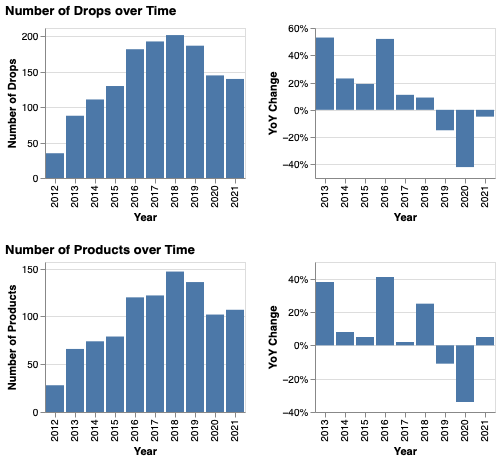

In [5]:
rel_per_year_df = pd.DataFrame(df_all.groupby('Year').count()['Product'])
prod_per_year_df = pd.DataFrame(all_products_df.groupby('Year').count()['Release']
)

(plots.plot_with_yoy(rel_per_year_df, 'Product', 'Drops').properties(title='Number of Drops over Time') 
& plots.plot_with_yoy(prod_per_year_df, 'Release', 'Products').properties(title='Number of Products over Time') )

In [6]:
# ytd_all_products_df = utils.drops_to_products(ytd_df, ['Year', 'Product'], 2021)
# rel_per_year_df = pd.DataFrame(ytd_df.groupby('Year').count()['Product'])
# prod_per_year_df = pd.DataFrame(ytd_all_products_df.groupby('Year').count()['Release']
# )

# (plots.plot_with_yoy(rel_per_year_df, 'Product', 'Drops').properties(title=f"Number of Drops by Year up to {rel.strftime('%b %d')}") 
# & plots.plot_with_yoy(prod_per_year_df, 'Release', 'Products').properties(title=f"Number of Products by up to {rel.strftime('%b %d')}"))

## Breakdown by Category

The category breakdown shows that the bulk of the gap to previous years comes in the clothes. The number of object drops has changed little since 2016; the big swings are in the number of clothing drops.

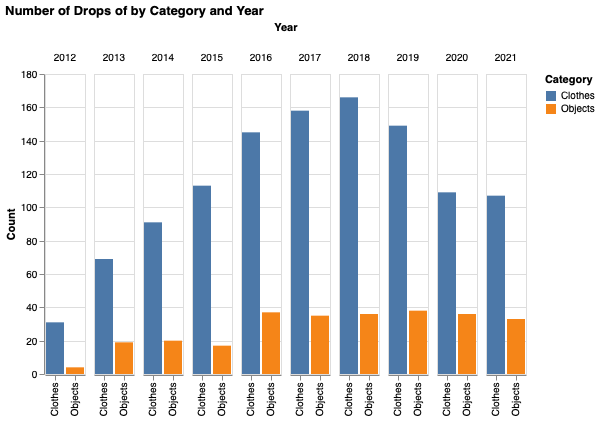

In [7]:
tdf = df_all.groupby(['Category', 'Year']).count()['Release'].reset_index()
# tdf = ytd_df.groupby(['Category', 'Year']).count()['Release'].reset_index()
tdf.columns = ['Category', 'Year', 'Count']
alt.Chart(tdf, width=40).mark_bar().encode(
    x=alt.X('Category:N', sort=kind_sort_order, title=None),
    y='Count:Q',
    color=alt.Color('Category:N', sort=kind_sort_order),
    column='Year:O',
    tooltip=['Count', ]
).configure_facet(spacing=7).properties(title=f"Number of Drops of by Category and Year")

In [8]:
# # tdf = df_all.groupby(['Category', 'Year']).count()['Release'].reset_index()
# tdf = ytd_df.groupby(['Category', 'Year']).count()['Release'].reset_index()
# tdf.columns = ['Category', 'Year', 'Count']
# alt.Chart(tdf, width=40).mark_bar().encode(
#     x=alt.X('Category:N', sort=kind_sort_order, title=None),
#     y='Count:Q',
#     color=alt.Color('Category:N', sort=kind_sort_order),
#     column='Year:O',
#     tooltip=['Count', ]
# ).configure_facet(spacing=7).properties(title=f"Number of Drops of by Category and Year up to {rel.strftime('%b %d')}")

Breaking clothes down by category adds detail to the picture. Pants/shorts are not too far off the pre-pandemic levels, and tops are not too much behind either: the main source of the gap is the cratering of the layers.

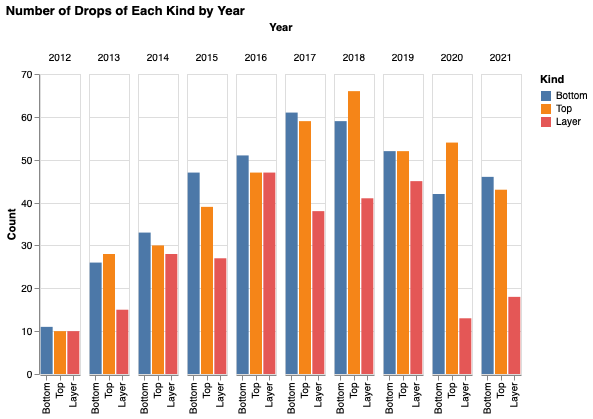

In [9]:
tdf = drops_to_clothes_drops(df_all).groupby(['Kind', 'Year']).count()['Release'].reset_index()
# tdf = drops_to_clothes_drops(ytd_df).groupby(['Kind', 'Year']).count()['Release'].reset_index()
tdf.columns = ['Kind', 'Year', 'Count']
alt.Chart(tdf, width=40).mark_bar().encode(
    x=alt.X('Kind:N', sort=kind_sort_order, title=None),
    y='Count:Q',
    color=alt.Color('Kind:N', sort=kind_sort_order),
    column='Year:O',
    tooltip=['Count', ]
).configure_facet(spacing=7).properties(title=f"Number of Drops of Each Kind by Year")

In [10]:
# # tdf = drops_to_clothes_drops(df_all).groupby(['Kind', 'Year']).count()['Release'].reset_index()
# tdf = drops_to_clothes_drops(ytd_df).groupby(['Kind', 'Year']).count()['Release'].reset_index()
# tdf.columns = ['Kind', 'Year', 'Count']
# alt.Chart(tdf, width=40).mark_bar().encode(
#     x=alt.X('Kind:N', sort=kind_sort_order, title=None),
#     y='Count:Q',
#     color=alt.Color('Kind:N', sort=kind_sort_order),
#     column='Year:O',
#     tooltip=['Count', ]
# ).configure_facet(spacing=7).properties(title=f"Number of Drops of Each Kind by Year up to {rel.strftime('%b %d')}")

## Breakdown by Quarter

To wrap this section up and bring the picture into clearer focus, we can look at drops by quarter. From the previous plots, it looks like the closer-to-normal 2021 was not so far ahead of heavily-impacted 2020. Visualizing the breakdown by quarter clarifies why this is. 2020 Q1, which the COVID pandemic only lightly impinged upon, was huge, much bigger than any previous Q1. Q2, Q3, and Q4 saw more drops in 2021 than 2020, but not by enough of a margin to make up the deficit from Q1.

In any case, number of drops are slowly recovering in 2021, but still quite a way off from where you would expect given the pre-COVID trend.

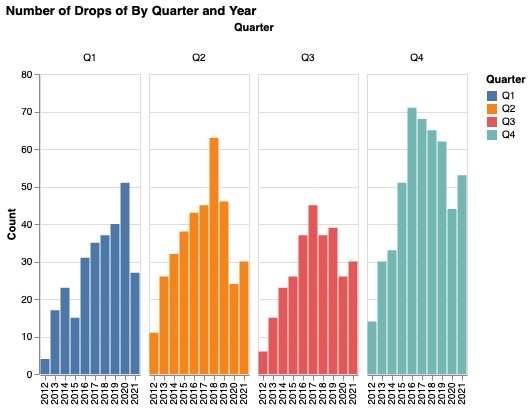

In [11]:
tdf = df_all.groupby(['Quarter', 'Year']).count()['Release'].reset_index()
# tdf = ytd_df.groupby(['Quarter', 'Year']).count()['Release'].reset_index()
tdf = tdf.rename(columns={"Release": "Count"})
alt.Chart(tdf, width=100).mark_bar().encode(
    x=alt.X('Year:N', sort=kind_sort_order, title=None),
    y='Count:Q',
    color=alt.Color('Quarter:N', sort=kind_sort_order),
    column='Quarter:O',
    tooltip=['Year', 'Count']
).configure_facet(spacing=7).properties(title=f"Number of Drops of By Quarter and Year")

In [12]:
# # tdf = df_all.groupby(['Quarter', 'Year']).count()['Release'].reset_index()
# tdf = ytd_df.groupby(['Quarter', 'Year']).count()['Release'].reset_index()
# tdf = tdf.rename(columns={"Release": "Count"})
# alt.Chart(tdf, width=100).mark_bar().encode(
#     x=alt.X('Year:N', sort=kind_sort_order, title=None),
#     y='Count:Q',
#     color=alt.Color('Quarter:N', sort=kind_sort_order),
#     column='Quarter:O',
#     tooltip=['Year', 'Count']
# ).configure_facet(spacing=7).properties(title=f"Number of Drops of By Quarter and Year up to {rel.strftime('%b %d')}")

## Is Outlier getting more expensive?

The appropriate, but unsatisfactory, answer is to the question of whether Outlier products are getting more expensive is, &ldquo;it depends on how you look at it.&rdquo;

In aggregate, the median nominal price in 2021 was $225, which higher than 2020, but the same as it was in 2019 and 2016 and lower than it was in 2017&ndash;2018. If we ignore 2020, which was a unique year, median nominal prices were in line with, or even a little less than, the past 5 years.

Looking at individual categories reveals a more nuanced picture, with bottoms becoming a little **less expensive** than in recent years and tops getting arguably a little _more expensive_.

The following plots show the price of products, grouped by year. Each dot is the *maximum nominal price* of one product within a calendar year. The category of product is indicated by the color of the dot. The red lines show the *median nominal price* for that year. The gray boxes indicate the 25&ndash;75 percentiles, so half of all drop prices for the year fall in that range. Mousing over a dot will show the name, nominal, and inflation-adjusted prices for the product.

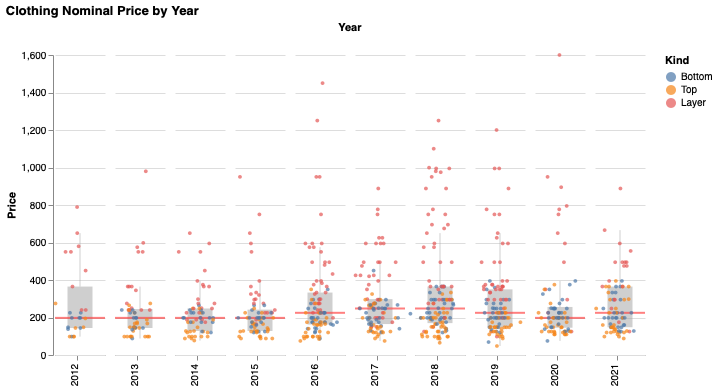

In [13]:
plots.price_plot(clothes_products_df, 'Kind', kind_sort_order).properties(title='Clothing Nominal Price by Year')

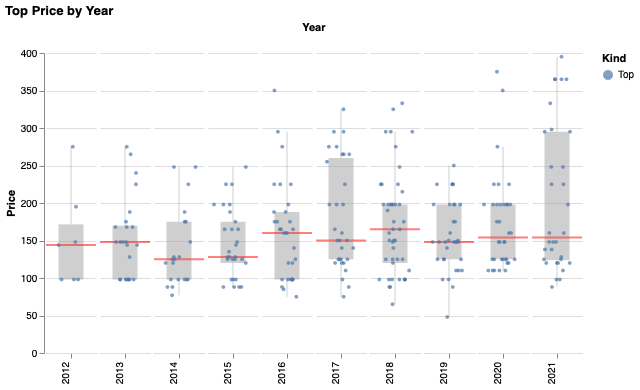

In [14]:
plots.price_plot(clothes_products_df[clothes_products_df['Kind'] == 'Top'], 
                 'Kind', 
                 kind_sort_order).properties(title='Top Price by Year')

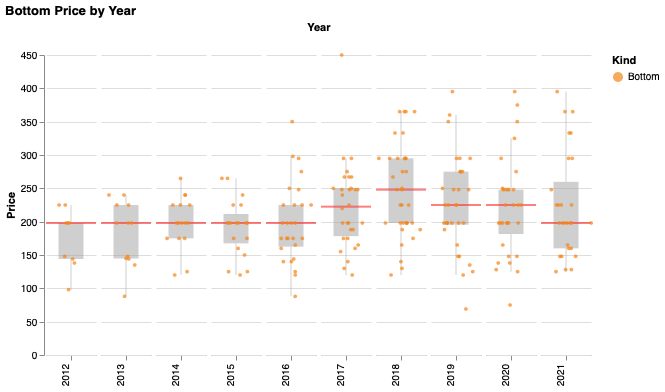

In [15]:
plots.price_plot(clothes_products_df[clothes_products_df['Kind'] == 'Bottom'], 
                 'Kind', 
                 kind_sort_order,
                 color_scale=alt.Scale(range=['#f58518'])).properties(title='Bottom Price by Year')

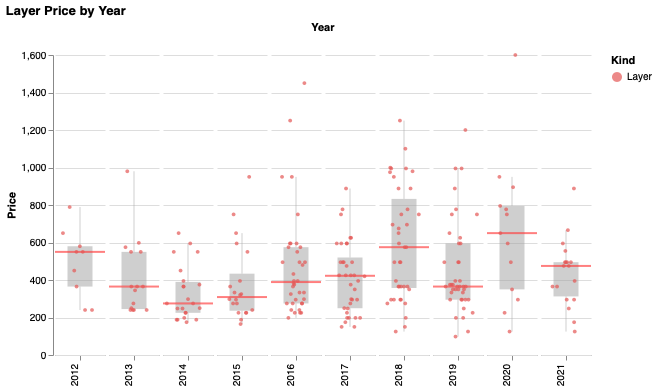

In [16]:
plots.price_plot(clothes_products_df[clothes_products_df['Kind'] == 'Layer'], 
                 'Kind', 
                 kind_sort_order,
                 color_scale=alt.Scale(range=['#e45756'])).properties(title='Layer Price by Year')

And what about experiments and objects? Those do seem to be getting more expensive.

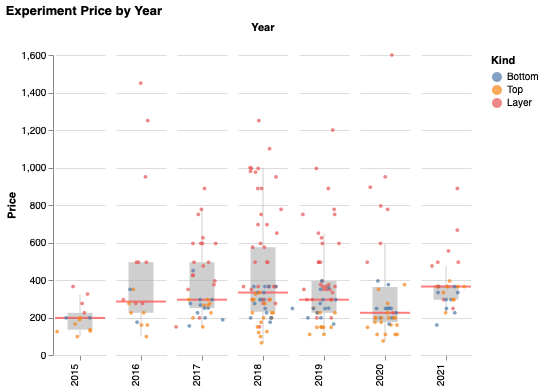

In [17]:
plots.price_plot(df_clothes[(df_clothes['Exp'] == True) & 
                            (df_clothes['Release'].dt.year > 2014)],
                 'Kind', 
                 kind_sort_order).properties(title='Experiment Price by Year')

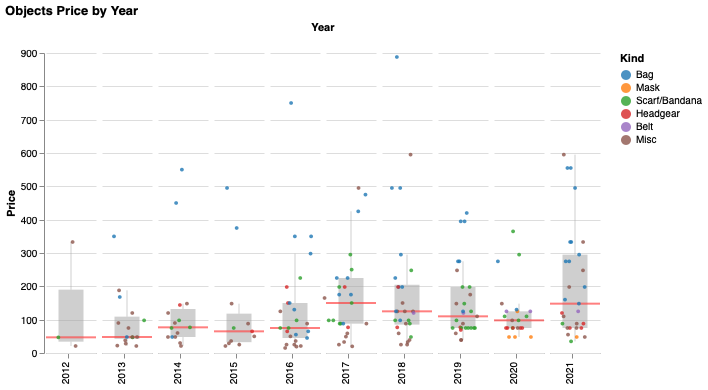

In [18]:
plots.price_plot(objects_products_df, 'Kind', object_kind_sort_order, 'Price',
                 'category10', 15, 0.8).properties(title='Objects Price by Year')

## Inflation-adjusted prices

The plots in the previous section used nominal prices. But $200 bought more in 2012 than it does in 2021, and a clearer understanding of the price evolution requires compensating for inflation. That is what the following versions of the plots do. They are the same as the ones above, except that the prices are adjusted for inflation using data from the [St. Louis Fed](https://fred.stlouisfed.org/series/PCEPILFE).

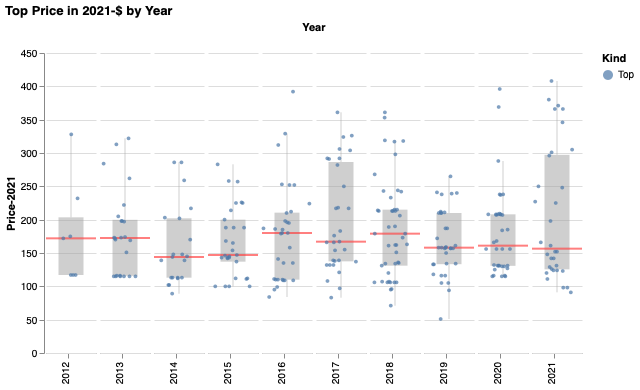

In [19]:
plots.price_plot(clothes_products_df[clothes_products_df['Kind'] == 'Top'], 
                 'Kind', 
                 kind_sort_order, f"Price-{year}").properties(
                 title=f"Top Price in {year}-$ by Year")

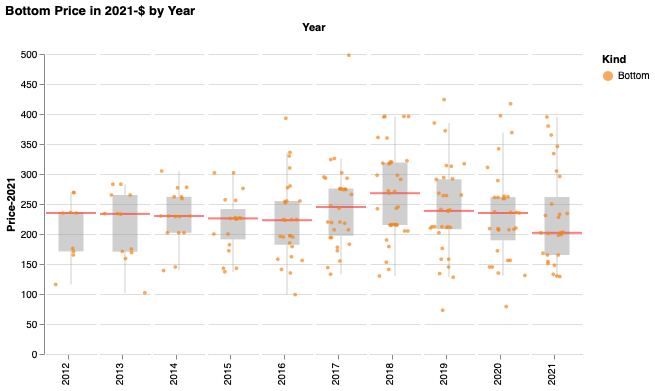

In [20]:
plots.price_plot(clothes_products_df[clothes_products_df['Kind'] == 'Bottom'], 
                 'Kind', 
                 kind_sort_order, f"Price-{year}",
                 color_scale=alt.Scale(range=['#f58518'])).properties(
                 title=f"Bottom Price in {year}-$ by Year")

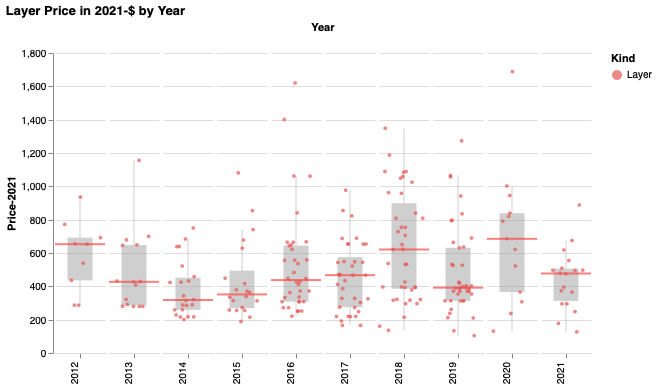

In [21]:
plots.price_plot(clothes_products_df[clothes_products_df['Kind'] == 'Layer'], 
                 'Kind', 
                 kind_sort_order, f"Price-{year}",
                 color_scale=alt.Scale(range=['#e45756'])).properties(
                 title=f"Layer Price in {year}-$ by Year")

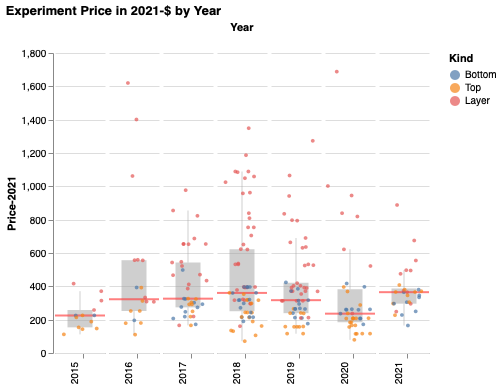

In [22]:
plots.price_plot(df_clothes[(df_clothes['Exp'] == True) & 
                            (df_clothes['Release'].dt.year > 2014)],
                 'Kind', 
                 kind_sort_order, f"Price-{year}").properties(
                 title=f"Experiment Price in {year}-$ by Year")

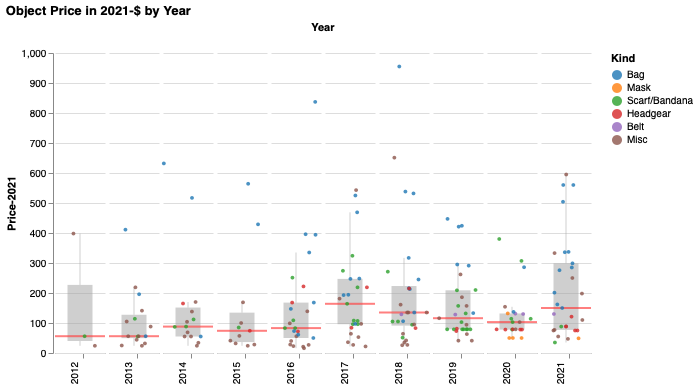

In [23]:
plots.price_plot(objects_products_df, 'Kind', object_kind_sort_order, f"Price-{year}",
                 'category10', 15, 0.8).properties(title=f"Object Price in {year}-$ by Year")

# Reups

- What were the most dropped items?
- How long do reups take?

What products got re-upped in 2021? The reups are probably more indicative of what was possible with the factories that were open and the fabric that was available, and the data might not provide much insight into where Outlier is trying to go with their product line.

In [24]:
reups = []
index = []
for name, tdf in df_clothes.groupby("Product"):
    drops = tdf.groupby('Year').count()['Release']
    cat = tdf['Type'].iloc[0]
    kind = tdf['Kind'].iloc[0]

    # Products dropped in 2012 - 2013
    if drops.loc[2012:2013].sum() > 0 and tdf['MWU'].iloc[0] != 'Women':
        index.append((kind, cat, name))
        reups.append(drops)
        continue
    # Add layers by default
    if kind == 'Layer' and tdf['MWU'].iloc[0] != 'Women':
        index.append((kind, cat, name))
        reups.append(drops)
        continue        
    # Products dropped in at least 3 times since 2014
    if drops.loc[2014:year].sum() > 2:
        index.append((kind, cat, name))
        reups.append(drops)
        continue
    # Products dropped at least 2 times in the last three years
    if drops.loc[2019:year].sum() > 1:
        index.append((kind, cat, name))
        reups.append(drops)
        continue
reups_df = pd.DataFrame(reups, index=pd.MultiIndex.from_tuples(index, names=['Kind', 'Type', 'Product']))
reups_df = reups_df.sort_index()
# reups_df.head()

The Bomb Dungarees and Bombworks have supplanted the Strongdarts, the Futureslimworks (né _Futureworks_), and Slim Dungarees as the most dropped bottoms.

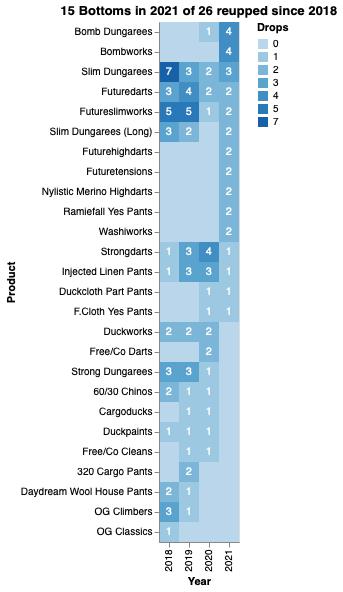

In [25]:
bottoms_df = reups_df.loc[('Bottom', 'Pants'), 2018:2021].dropna(axis=0, how='all')
title_bottoms = "{} Bottoms in 2021 of {} reupped since 2018".format(len(bottoms_df.loc[:,2021].dropna()), len(bottoms_df))
plots.drop_chart(bottoms_df.sort_values(list(range(2021, 2018, -1)), ascending=False)).properties(title=title_bottoms)

Whereas in the past, an office-compatible button-up shirt enjoyed a reup or two every year (Nyco Oxford, AMB Button Up), this year, the the Nylistic Merino Traveler was the only shirt that got reupped more than once.

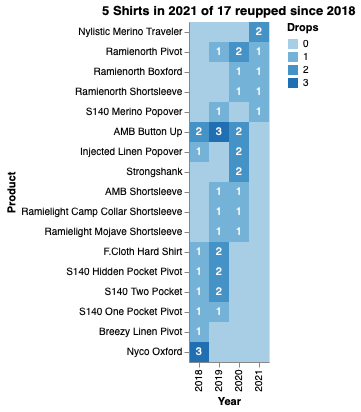

In [26]:
tops_df = reups_df.loc[('Top', 'Shirt'), 2018:2021].dropna(axis=0, how='all')
title_tops = "{} Shirts in 2021 of {} reupped since 2018".format(len(tops_df.loc[:,2021].dropna()), len(tops_df))
plots.drop_chart(tops_df.sort_values(list(range(2021, 2018, -1)), ascending=False)).properties(title=title_tops)

In t-shirts, as you would expect, the Ultrafine Merino Cut One was most reupped, together with the relatively new Cottonweight Billboard.

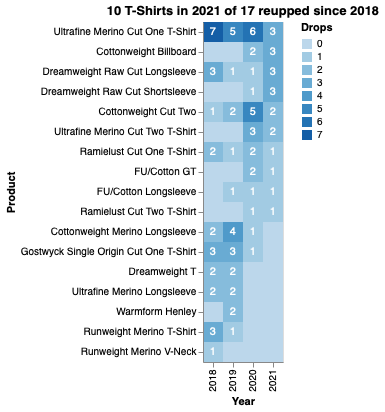

In [27]:
tops_df = reups_df.loc[('Top', 'T-Shirt'), 2018:2021].dropna(axis=0, how='all')
title_tops = "{} T-Shirts in 2021 of {} reupped since 2018".format(len(tops_df.loc[:,2021].dropna()), len(tops_df))
plots.drop_chart(tops_df.sort_values(list(range(2021, 2018, -1)), ascending=False)).properties(title=title_tops)

## Time between drops by category

Say you want a pair of pants or shorts from Outlier: how long do you have to wait for the next drop?

In [28]:
def since_last_kind_df(clothes_drops_df, kind):
    tdf = clothes_drops_df[clothes_drops_df['Kind'] == kind]
    columns = ['Product', 'Type', 'Category', 'Kind', 'Year', 'Price', adjusted_price_col]
    tdf = tdf.set_index(columns)
    tdf = tdf.set_index('Release', drop=False, append=True)
    tser = tdf['Release'].diff().shift(-1)
    tser = tser * -1 / np.timedelta64(7, 'D')
    tser = pd.to_numeric(tser.dropna(), downcast='integer')
    tser = tser[tser > 0]
    tser.name = 'Weeks Since Last'
    return tser.reset_index()

Before the pandemic, tops got dropped on a weekly basis most of the the time. This went up to almost two weeks between drops in aggregate in 2020 and started to come down this year, but still remains higher than in the past.

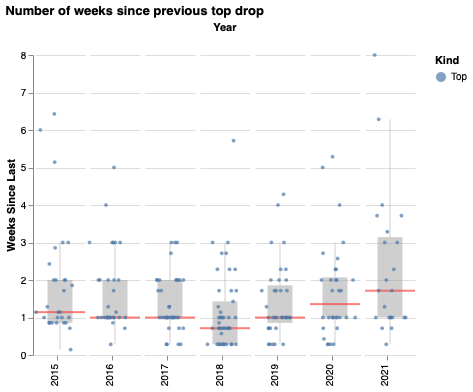

In [29]:
tdf = drops_to_clothes_drops(ytd_df)
ttdf = since_last_kind_df(tdf, 'Top')
ttdf = ttdf[ttdf['Year'] > 2014]
plots.facetted_scatter(ttdf, 
                       'Kind', 
                       kind_sort_order, 
                       'Weeks Since Last').properties(
                        title='Number of weeks since previous top drop',
                        )

The time between bottoms has stayed quite constant, with bottoms generally dropping every week.

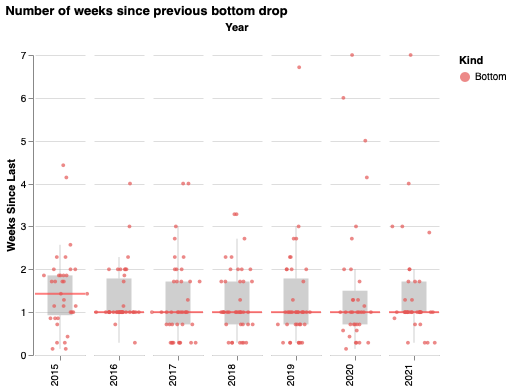

In [30]:
ttdf = since_last_kind_df(tdf, 'Bottom')
ttdf = ttdf[ttdf['Year'] > 2014]
plots.facetted_scatter(ttdf, 
                       'Kind', 
                       kind_sort_order, 
                       'Weeks Since Last',
                       color_scale=alt.Scale(range=['#e45756'])).properties(
                        title='Number of weeks since previous bottom drop')

Layers were never dropped as frequently as tops and bottoms, and as with tops, the time between layer drops has gone up and stayed higher during the last two years.

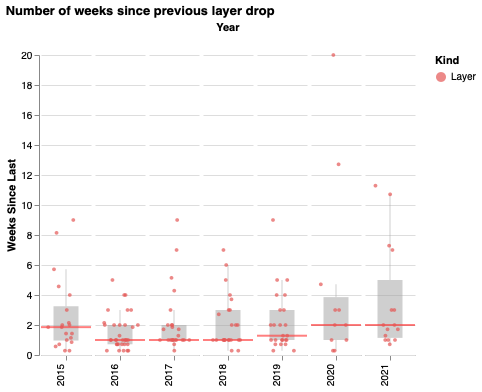

In [31]:
ttdf = since_last_kind_df(tdf, 'Layer')
ttdf = ttdf[ttdf['Year'] > 2014]
plots.facetted_scatter(ttdf, 
                       'Kind', 
                       kind_sort_order, 
                       'Weeks Since Last',
                       color_scale=alt.Scale(range=['#e45756'])).properties(
                       title='Number of weeks since previous layer drop')

## Time between re-ups

Of the products that got re-upped, how long was the median wait between re-ups? For seasonal products, those that might see a few reups in the summer, this median will generally show the wait time during the season.

In [32]:
def compute_reups_weeks_df(products):
    tdf = df_clothes[df_clothes['Product'].isin(products)]
    tdf = tdf.set_index(['Product', 'Type', 'Category', 'Year'])
    ttdf = tdf.groupby(level=['Product', 'Type', 'Category'])['Release'].diff().dropna()
    # could also use mean here
    reups_weeks_ser = ttdf.groupby(level=['Product', 'Type', 'Category', 'Year']).median() / np.timedelta64(-24 * 7, 'h')
    reups_weeks_df = reups_weeks_ser.reset_index().pivot('Product', 'Year', 'Release').round()
    # reups_weeks_df = reups_weeks_df.dropna(axis=0, how='all')
    return reups_weeks_df

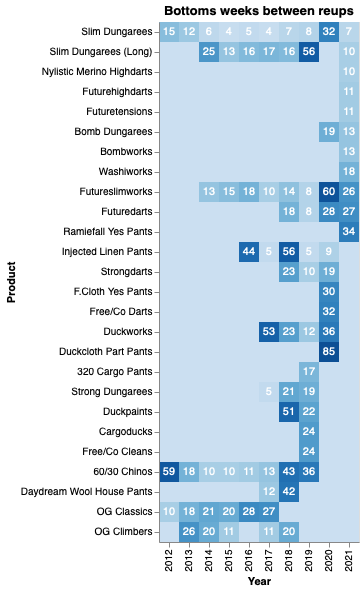

In [33]:
reups_weeks_df = compute_reups_weeks_df(bottoms_df.index)
plots.drop_reup_chart(reups_weeks_df.sort_values(list(range(2021, 2018, -1)), ascending=True)).properties(title="Bottoms weeks between reups")

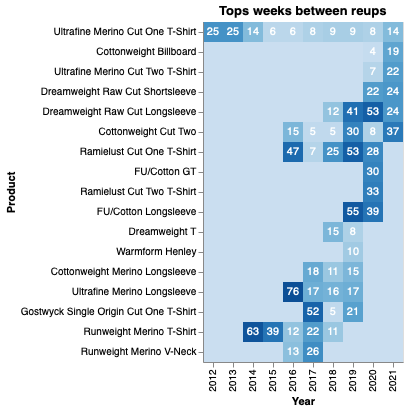

In [34]:
reups_weeks_df = compute_reups_weeks_df(tops_df.index)
plots.drop_reup_chart(reups_weeks_df.sort_values(list(range(2021, 2018, -1)), ascending=True)).properties(title="Tops weeks between reups")

# Colors

Now we turn our attention to colors. If we look back to the early 2010s, it feels like most drops focused on black, charcoal, and navy, with only occasional color variations dropped in.

How has variety in colors been developing? There have always been products that came out in many colorways (e.g., SDs in 2015–2018 or 60/30 Chinos in 2014–2017), but whereas the colorways were spread out over more drops in the past, now each drop will include greater variety of colors.

In [35]:
def unique_color_counts(df):
    tdf = df.dropna(subset=["Colors"])
    colors = tdf['Colors'].str.split(",").values
    if len(colors) < 1:
        return 0
    return len(np.unique([c.strip() for c in np.concatenate(colors)]))


def colors_per_year_plot(df):
    tdf = df.groupby(['Product', 'Year']).apply(unique_color_counts).unstack()
    tdf = tdf.sort_values(year_sort, ascending=False)
    return plots.color_count_chart(tdf).properties(title="Number of unique colors per year")

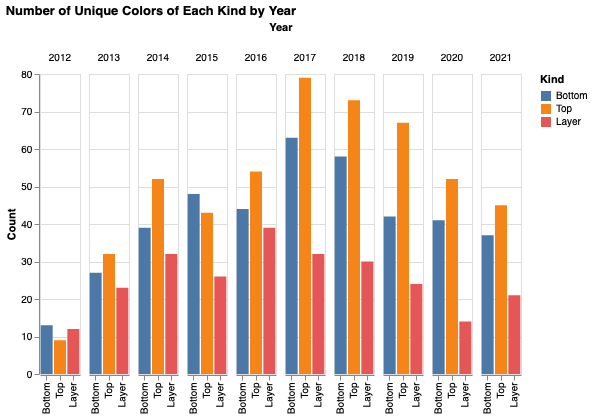

In [36]:
tdf = drops_to_clothes_drops(df_all).groupby(['Kind', 'Year']).apply(unique_color_counts).reset_index()
tdf.columns = ['Kind', 'Year', 'Count']
alt.Chart(tdf, width=40).mark_bar().encode(
    x=alt.X('Kind:N', sort=kind_sort_order, title=None),
    y='Count:Q',
    color=alt.Color('Kind:N', sort=kind_sort_order),
    column='Year:O',
    tooltip=['Count', ]
).configure_facet(spacing=7).properties(title=f"Number of Unique Colors of Each Kind by Year")

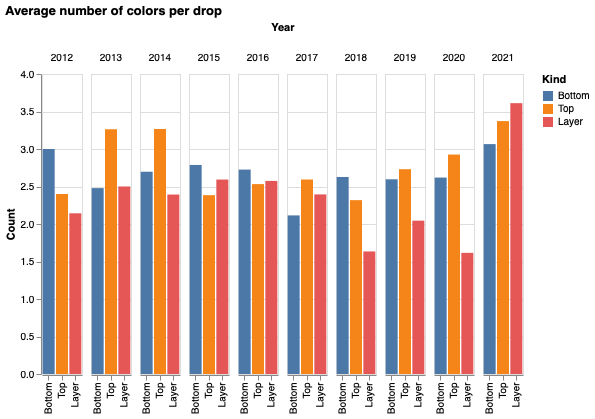

In [37]:
tdf = drops_to_clothes_drops(df_all).groupby(['Kind', 'Year'])['ColorCount'].mean().reset_index()
tdf.columns = ['Kind', 'Year', 'Count']
alt.Chart(tdf, width=40).mark_bar().encode(
    x=alt.X('Kind:N', sort=kind_sort_order, title=None),
    y='Count:Q',
    color=alt.Color('Kind:N', sort=kind_sort_order),
    column='Year:O',
    tooltip=['Count', ]
).configure_facet(spacing=7).properties(title=f"Average number of colors per drop")

## Color Detail

For the reupped products, how many colors dropped in each year?

### Bottoms

In [38]:
bottoms_df = reups_df.loc[('Bottom'), 2018:2021].dropna(axis=0, how='all')
bottoms_df = bottoms_df.loc[bottoms_df.sum(axis=1) > 3].reset_index(0, drop=True)

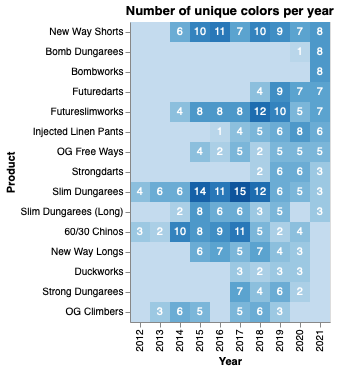

In [39]:
colors_per_year_plot(df_clothes[df_clothes['Product'].isin(bottoms_df.index)])

### Tops

In [40]:
tops_df = reups_df.loc[('Top'), 2018:2021].dropna(axis=0, how='all')
tops_df = tops_df.loc[tops_df.sum(axis=1) > 3].reset_index(0, drop=True)

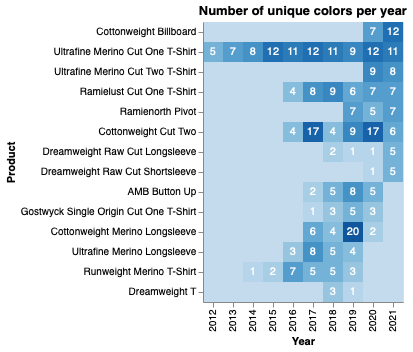

In [41]:
colors_per_year_plot(df_clothes[df_clothes['Product'].isin(tops_df.index)])

### Color Names

What are the most popular colors in 2021? Here they are along with with the percentage of drops that used this color.

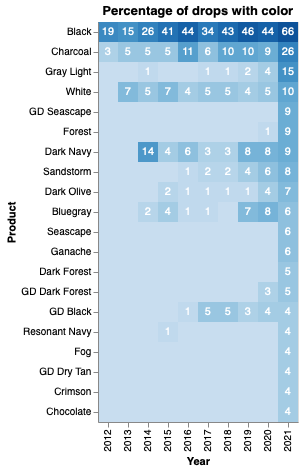

In [42]:
def unique_color_name_counts(df):
    tdf = df.dropna(subset=["Colors"])
    colors = tdf['Colors'].str.split(",").values
    if len(colors) < 1:
        return []
    colors = np.concatenate(colors)
    color_counts = {}
    for col in colors:
        c = col.strip()
        count = color_counts.get(c)
        if count is None:
            color_counts[c] = 1
        else:
            color_counts[c] = count + 1    
    return pd.DataFrame([{"color": k, "count":v} for k, v in color_counts.items()])


color_names_dfs = []
for year, gdf in df_clothes.groupby('Year'):
    tdf = unique_color_name_counts(gdf)
    tdf['count_per_drop'] = tdf['count'] / len(gdf)
    tdf['year'] = year
    color_names_dfs.append(tdf)
color_names_df = pd.concat(color_names_dfs)
color_names_df = color_names_df.set_index(['color', 'year'])

tdf = color_names_df['count_per_drop'].unstack()
tdf = tdf.sort_values(2021, ascending=False)
tdf = tdf[tdf[2021] > 0.045] * 100
tdf = tdf.fillna(0).astype("int8")
plots.color_count_chart(tdf).properties(title="Percentage of drops with color")

# Fabrics

And to close, let us look at fabrics. Outlier still uses a wide array of fabrics in their product palette, but the number of fabrics in 2021 is down almost a third from the peak in 2019 (32 fabrics in 2021 vs. 45 in 2019), though, as with many things, this is probably more a side-effect of supply-chain disruptions than a change in direction.

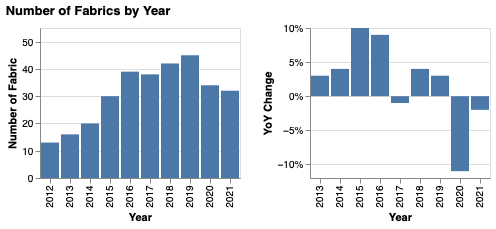

In [43]:
# Fix fabric names
clothes_products_df.loc[clothes_products_df['Fabric'] == 'FU/Cotton Jersey', 'Fabric'] = 'Cotton'
clothes_products_df.loc[clothes_products_df['Fabric'] == 'LA Apparel Cotton', 'Fabric'] = 'Cotton'
fabrics_df = clothes_products_df.groupby(['Fabric', 'Year']).count()['Release'].unstack()
# fabrics_df.head()

fabrics_year_df = pd.DataFrame(fabrics_df.stack().reset_index().groupby('Year').count()['Fabric'])
plots.plot_with_yoy(fabrics_year_df, 'Fabric', 'Fabric').properties(title='Number of Fabrics by Year')

There were several fabrics that got tested in a small number of products this year, as every year.

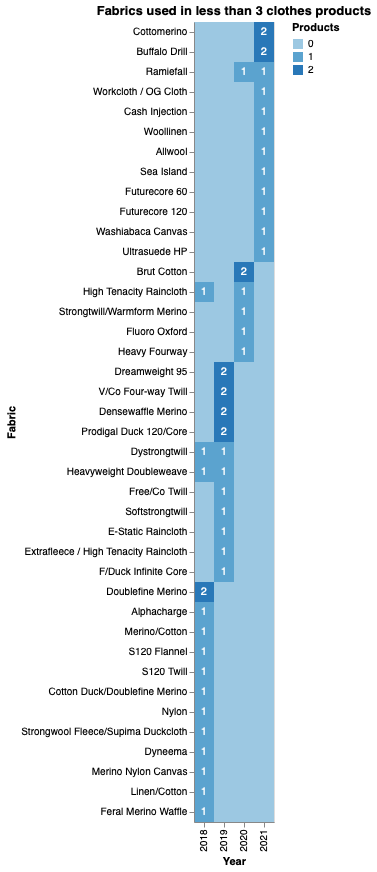

In [44]:
fdf = fabrics_df.loc[:,2018:2021]
fabrics_cum_ser = fdf.sum(axis=1).sort_values(ascending=False)
fabrics_cum_ser = fabrics_cum_ser[fabrics_cum_ser > 0]
fabric_partition = fabrics_cum_ser.describe()
lower_50_ser = fabrics_cum_ser[fabrics_cum_ser <= fabric_partition.loc['50%']]
lower_50_fabrics = lower_50_ser.index
plots.fabric_chart(fdf.loc[lower_50_fabrics].sort_values(recent_year_sort, ascending=False)).properties(title="Fabrics used in less than 3 clothes products")

F. Cloth remains the most widely used fabric, appearing in 10 (clothing) products. And 2021 included a few staple and several experiments with Injected Linen, making it the second most widely used fabric this year. 

Fabrics that have been diminishing in use include Duckcloth, which was used in five products last year, but only 2 this year, and historical favorite, Strongtwill.

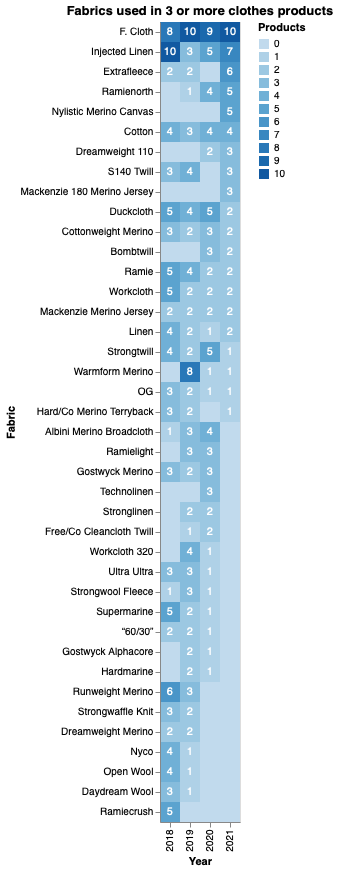

In [45]:
upper_50_ser = fabrics_cum_ser[fabrics_cum_ser > fabric_partition.loc['50%']]
upper_50_ser = upper_50_ser[upper_50_ser > 0]
upper_50_fabrics = upper_50_ser.index

plots.fabric_chart(fdf.loc[upper_50_fabrics].sort_values(recent_year_sort, ascending=False)).properties(title="Fabrics used in 3 or more clothes products")

# 2022

Since 2021 seemed to be a year where it was impossible to fire on all cylinders, I will not bother trying to speculate about what all this information foreshadows for the future. Let's see what develops in 2022.